# Ibis+Vega+Altair using an interactive slider

We will try to reproduce [this](https://altair-viz.github.io/gallery/us_population_over_time.html)
example from the Altair gallery, but with lazily fetching data as the user interacts with the slider.
To keep ourselves honest, we'll be putting the data in a SQLite database.

First, let's show the original example, without any modifications:

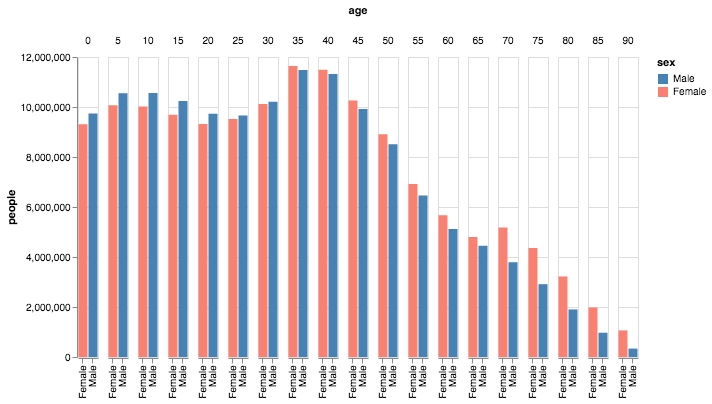

In [1]:
import altair as alt
from vega_datasets import data

source = data.population.url

pink_blue = alt.Scale(domain=('Male', 'Female'),
                      range=["steelblue", "salmon"])

slider = alt.binding_range(min=1900, max=2000, step=10)
select_year = alt.selection_single(name="year", fields=['year'],
                                   bind=slider, init={'year': 2000})

alt.Chart(source).mark_bar().encode(
    x=alt.X('sex:N', title=None),
    y=alt.Y('people:Q', scale=alt.Scale(domain=(0, 12000000))),
    color=alt.Color('sex:N', scale=pink_blue),
    column='age:O'
).properties(
    width=20
).add_selection(
    select_year
).transform_calculate(
    "sex", alt.expr.if_(alt.datum.sex == 1, "Male", "Female")
).transform_filter(
    select_year
).configure_facet(
    spacing=8
)

## Loading the data into a database

We begin our lazy-fetching example by downloading the data and putting it into a SQLite database:

In [2]:
import sqlalchemy
dbfile = 'population.db'
engine = sqlalchemy.create_engine(f'sqlite:///{dbfile}')

import pandas as pd
df = pd.read_json(data.population.url)
df.to_sql('population', engine, if_exists='replace')

Now, let's create an ibis connection to this database and verify that the data is there:

In [3]:
import ibis

connection = ibis.sqlite.connect(dbfile)
connection.list_tables()

['population']

We can use inspect the data using this ibis connection:

In [4]:
pop = connection.table('population')
pop.head().execute()

,index,age,people,sex,year
0,0,0,1483789,1,1850
1,1,0,1450376,2,1850
2,2,5,1411067,1,1850
3,3,5,1359668,2,1850
4,4,10,1260099,1,1850


## Making an interactive plot

We are now ready to make an interactive plot using this database connection.
We can reuse the same objects for `pink_blue`, `slider`, and `select_year`, as they are independent of the data source.
The `Chart` specifiation is completely identical, except that instead of the pandas dataframe,
we supply it with the Ibis sqlite connection:

In [5]:
import jupyterlab_omnisci.vega_ibis

alt.renderers.enable('ibis')
alt.data_transformers.enable('ibis')

alt.Chart(pop).mark_bar().encode(
    x=alt.X('sex:N', title=None),
    y=alt.Y('people:Q', scale=alt.Scale(domain=(0, 12000000))),
    color=alt.Color('sex:N', scale=pink_blue),
    column='age:O'
).properties(
    width=20
).add_selection(
    select_year
).transform_calculate(
    "sex", alt.expr.if_(alt.datum.sex == 1, "Male", "Female")
).transform_filter(
    select_year
).configure_facet(
    spacing=8
)

Chart({
  config: Config({
    facet: CompositionConfig({
      spacing: 8
    })
  }),
  data: Empty DataFrame
  Columns: [index, age, people, sex, year]
  Index: [],
  encoding: FacetedEncoding({
    color: Color({
      scale: Scale({
        domain: ('Male', 'Female'),
        range: ['steelblue', 'salmon']
      }),
      shorthand: 'sex:N'
    }),
    column: Column({
      shorthand: 'age:O'
    }),
    x: X({
      shorthand: 'sex:N',
      title: None
    }),
    y: Y({
      scale: Scale({
        domain: (0, 12000000)
      }),
      shorthand: 'people:Q'
    })
  }),
  mark: 'bar',
  selection: {'year': SelectionDef({
    bind: BindRange({
      input: 'range',
      max: 2000,
      min: 1900,
      step: 10
    }),
    fields: ['year'],
    init: {'year': 2000},
    type: 'single'
  })},
  transform: [CalculateTransform({
    as: 'sex',
    calculate: if((datum.sex === 1),'Male','Female')
  }), FilterTransform({
    filter: {'selection': 'year'}
  })],
  width: 20
})